In [179]:
# machine learning modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv1D, Conv1DTranspose
from tensorflow.keras.constraints import max_norm

# Visualization of data
import matplotlib.pyplot as plt

import os
import mne
import math

import numpy as np
from mne.datasets import spm_face
from mne.preprocessing import ICA, create_eog_epochs
from mne import io, combine_evoked

# Connects to the database
import mysql.connector

# Load in Noisy MEG dataset
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_filt-0-40_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file)
# Here we'll crop to 60 seconds and drop gradiometer channels for speed
raw.crop(tmax=60.).pick_types(meg='mag', eeg=True, stim=True, eog=True)
raw.load_data()

# Load in Clean Data
Clean_raw = mne.io.read_raw_fif("Clean_Data/Clean_raw.fif")

Opening raw data file C:\Users\shamd\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 9009  =      0.000 ...    59.999 secs...
Opening raw data file Clean_Data/Clean_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 15459 =     42.956 ...   102.954 secs
Ready.


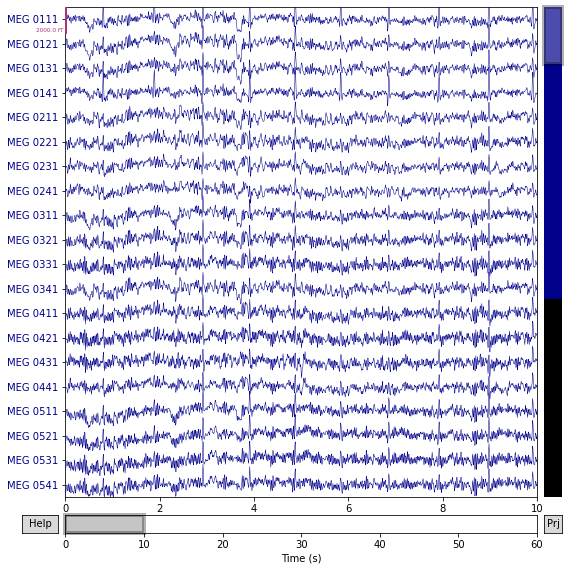

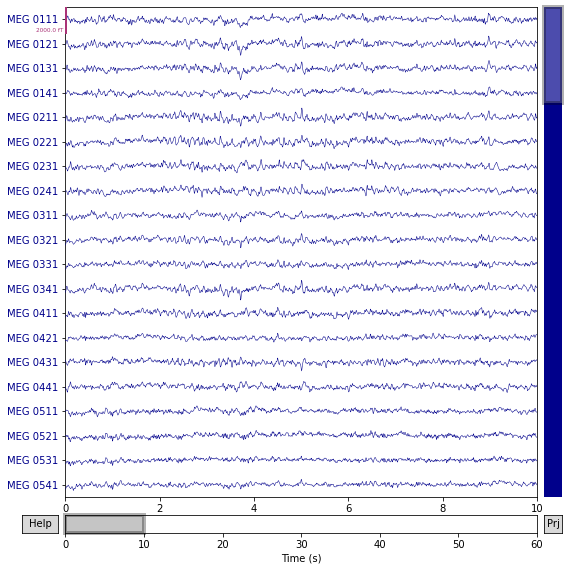

Created an SSP operator (subspace dimension = 3)
4 projection items activated
SSP projectors applied...


<Raw | Clean_raw.fif, 102 x 9010 (60.0 s), ~3.0 MB, data not loaded>

In [168]:
raw.plot(proj=False)
Clean_raw.plot()

Clean_raw.apply_proj()

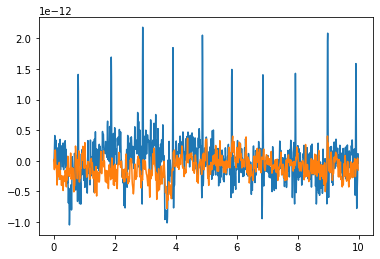

In [169]:
sampling_freq = raw.info['sfreq']
start_stop_seconds = np.array([0, 10])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
raw_selection = raw['MEG 0111', start_sample:stop_sample]
Clean_raw_selection = Clean_raw['MEG 0111', start_sample:stop_sample]

x = raw_selection[1]   # time
n_y = raw_selection[0].T # data array transposed
x = x[:1500:]
n_y = n_y[:1500:]
plt.plot(x, n_y)
# Plotting Clean signal (Orange)
p_y = Clean_raw_selection[0].T
p_y = p_y[:1500:]
plt.plot(x, p_y)
plt.show()

In [170]:
num_of_samples = 2
# Containers for samples.
noisy_samples = []
pure_samples = []

for j in range(0,num_of_samples):      
    # Append to noisy Samples
    noisy_samples.append(n_y)  
    # Append to clean Samples
    pure_samples.append(p_y)

In [171]:
print("Going to next computations...\n")
noisy_samples = np.array(noisy_samples)
pure_samples = np.array(pure_samples)

y_val_noisy = noisy_samples
y_val_pure  = pure_samples

# Normalize data using Min-Max Normalization
np.seterr(invalid='ignore')
y_val_noisy_r = []
y_val_pure_r = []
for i in range(0, len(y_val_noisy)):
    noisy_sample = y_val_noisy[i]
    pure_sample = y_val_pure[i]
    noisy_sample = np.nan_to_num((noisy_sample - np.min(noisy_sample)) / (np.max(noisy_sample) - np.min(noisy_sample)))
    pure_sample = np.nan_to_num((pure_sample - np.min(pure_sample)) / (np.max(pure_sample) - np.min(pure_sample)))
    y_val_noisy_r.append(noisy_sample)
    y_val_pure_r.append(pure_sample)
    
# Reshape data in order to pass through model.
y_val_noisy_r   = np.array(y_val_noisy_r)
y_val_pure_r    = np.array(y_val_pure_r)
noisy_input     = y_val_noisy_r.reshape((y_val_noisy_r.shape[0], y_val_noisy_r.shape[1], 1))
pure_input      = y_val_pure_r.reshape((y_val_pure_r.shape[0], y_val_pure_r.shape[1], 1))  

Going to next computations...



In [172]:
# load json and create model
json_file = open('model_two.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_two.h5")
print("Loaded model from disk")
loaded_model.compile(optimizer='adam', loss='binary_crossentropy')

Loaded model from disk


1/1 [==============================] - 0s 216ms/step


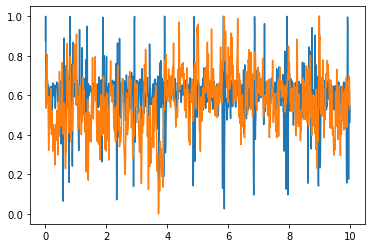

In [173]:
train_test_split = 0.3
validation_split = 0.3

# Train/test split
percentage_training = math.floor((1 - train_test_split) * len(noisy_input))
noisy_input, noisy_input_test = noisy_input[:percentage_training], noisy_input[percentage_training:]
pure_input, pure_input_test = pure_input[:percentage_training], pure_input[percentage_training:]

# Generate reconstructions
num_reconstructions = 1
samples = noisy_input_test[:num_reconstructions]
reconstructions = loaded_model.predict(samples)

plt.plot(c_x, reconstructions[0])
plt.plot(c_x, pure_input[0])
plt.show()

In [174]:
noise = noisy_input[0] - pure_input[0]
r = np.abs(noise)**2
r = np.sum(r)
signal = np.sum(np.abs(pure_input[0])**2)
SNR = 10 * math.log10(signal/r)
print(SNR)

5.98382352595481


In [175]:
noise = reconstructions[0] - pure_input[0]
r = np.abs(noise)**2
r = np.sum(r)
signal = np.sum(np.abs(pure_input[0])**2)
SNR = 10 * math.log10(signal/r)
print(SNR)

10.082410034494497


In [176]:
# Connecting to the Database
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="",
)

mycursor = mydb.cursor()

mycursor.execute("CREATE DATABASE IF NOT EXISTS Biomedical")

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="",
  database="Biomedical"
)

mycursor = mydb.cursor()

mycursor.execute("CREATE TABLE IF NOT EXISTS Signals (ynoise DOUBLE(31,30), yclean DOUBLE(31,30), yrec FLOAT(9,8))")

recarray = np.ravel(reconstructions).tolist()
for i in range(0,len(y_val_noisy)):
    sql = "INSERT INTO signals (ynoise, yclean,yrec) VALUES (%s, %s, %s)"
    valone = y_val_noisy[0][i][0]
    valtwo = y_val_pure[0][i][0]
    valthree = recarray[i]
    val = [(valone,valtwo,valthree)]
    mycursor.executemany(sql, val)
    mydb.commit()